# Final Tutorial: Spotify Data

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
data = pd.read_csv("spotify-dataset-19212020-160k-tracks/data.csv")

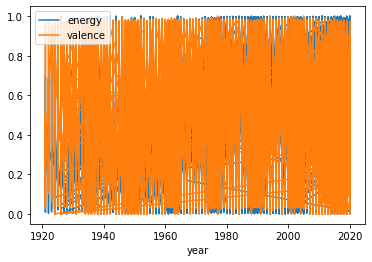

In [36]:
data.plot(x="year", y=["energy", "valence"], kind="line")

In [52]:
plot_data = data.groupby('year', as_index = False)[['energy', 'valence', 'danceability']].mean()

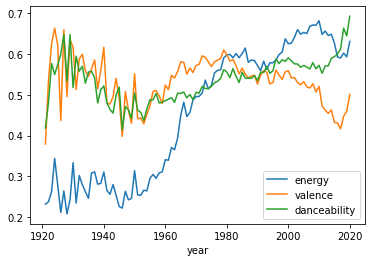

In [48]:
plot_data.plot(x="year", y=['energy', 'valence', 'danceability'], kind='line')

In [187]:
key_data = data.loc[:, ('year', 'key')]
key_data['key_frequency'] = 1
key_data = key_data[key_data['year'] >= 2010]
plot_data = key_data.groupby(['year', 'key'], as_index = False)['key_frequency'].agg({'key_frequency': 'sum'})

year_counts = key_data.groupby(['year']).agg({'key_frequency': 'sum'})
year_counts.columns = ['song_count']
plot_data = plot_data.join(year_counts, on='year')
plot_data['key_frequency'] = plot_data['key_frequency'].div(plot_data['song_count'])*100
plot_data = plot_data.pivot(index = 'year', columns = 'key', values = 'key_frequency')



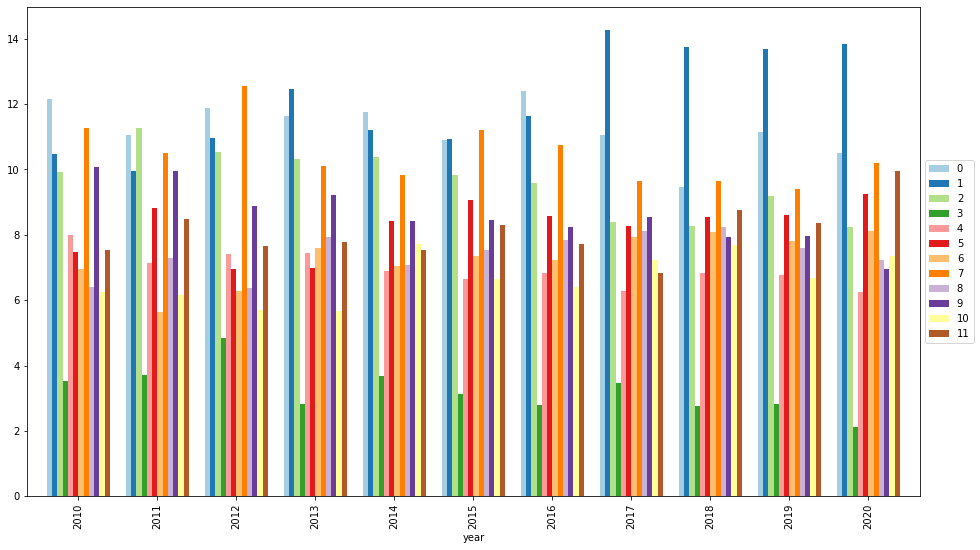

In [188]:
fig = plt.figure()
ax = fig.add_subplot(111)
cm = plt.get_cmap('Paired')
color = [cm(1.*i/12) for i in range(35)]
plot_data.plot(kind = 'bar', ax = ax, figsize=(16,9), width=0.8, color=color)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [50]:
list(data)

['valence',
 'year',
 'acousticness',
 'artists',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'id',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'name',
 'popularity',
 'release_date',
 'speechiness',
 'tempo']